# Анализ данных в задаче кредитного скоринга

#### Импортируем все необходимые библиотеки

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import *
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

D:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Загружаем данные

In [8]:
data = pd.read_csv("credit_card_default_analysis.csv")
data.drop(["ID"], axis = 1, inplace = True)
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,0,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,0,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,0,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### Задание 1. Размер кредитного лимита (LIMIT_BAL)

Нарисуем графики и разобьем данные на две подвыборки согласно критерию о возврате долга (default group и non-default group):

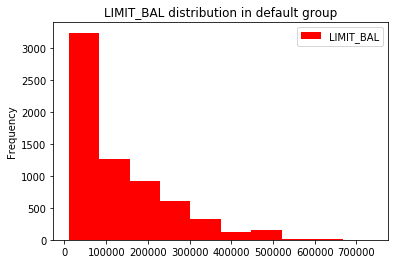

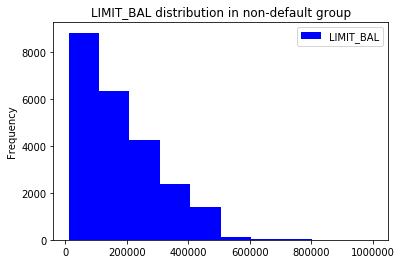

In [92]:
data_def = data[data['default'] == 1]
data_non_def = data[data['default'] == 0]

data_def.plot(y='LIMIT_BAL', kind='hist', 
               color='red',  title='LIMIT_BAL distribution in default group')
data_non_def.plot(y='LIMIT_BAL', kind='hist', 
               color='blue',  title='LIMIT_BAL distribution in non-default group')

Из графиков видно, что медиана кредитного лимита тех, кто не вернул долг (красный график), лежит левее.

Также можно предположить, что и все распределение default group сильнее скошено.

#### Проверим гипотезу А 
Требуется проверить гипотезу о равенстве медианных значений кредитного лимита с помощью интервальной оценки. Из графиков видно, что кредитный лимит распределен не нормально, поэтому воспользуемся bootstrap-ом аналогично тому, как мы действовали в лекциях.

In [47]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [48]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [63]:
#Здесь мы строим по 1000 псевдоподвыборок из двух данных и находим медианные значения для них.
default_limits = data_def.LIMIT_BAL.values
non_default_limits = data_non_def.LIMIT_BAL.values

default_median_scores = list(map(np.median, get_bootstrap_samples(default_limits, 1000)))
non_default_median_scores = list(map(np.median, get_bootstrap_samples(non_default_limits, 1000)))

In [64]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(default_median_scores, non_default_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


Полученная интервальная оценка разности медиан не включает 0, значит, можно на уровне значимости 0.05 отвергнуть гипотезу о равенстве медиан кредитного лимита для данных групп.

#### Проверим гипотезу B
Требуется проверить гипотезу о равенстве распределений с помощью одного из непараметрических критериев проверки равенства средних. Используем ранговый критерий Манна-Уитни, потому что он является двухвыборочным критерием для независимых выборок (очевидно, выборки default и non-default независимы). Проверяется следующая гипотеза:

$H_0\colon F_{X_{def}}(x) = F_{X_{non}}(x)$

$H_1\colon F_{X_{def}}(x) = F_{X_{non}}(x + \Delta), \Delta\neq 0$

In [138]:
print("p-value is", stats.mannwhitneyu(default_limits, non_default_limits)[1])

p-value is 6.127742909111652e-190


Нулевая гипотеза отвергается на уровне значимости 0.05 в пользу альтернативы.

Полученные результаты значимы с практической точки зрения, так как размер кредитного лимита непосредственно связан риском не возврата кредита.

### Задание 2. Пол (SEX)

Нарисуем графики, иллюстрирующие гендерный состав:

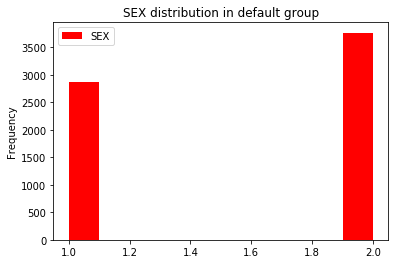

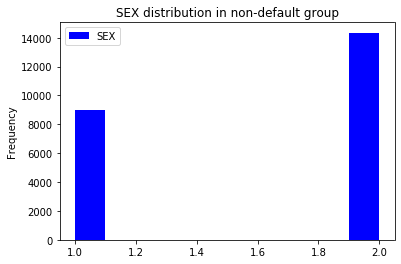

In [72]:
data_def.plot(y='SEX', kind='hist', 
               color='red',  title='SEX distribution in default group')
data_non_def.plot(y='SEX', kind='hist', 
               color='blue',  title='SEX distribution in non-default group')

Визуально графики практически неразличимы между собой (с учетом масштабирования групп).

#### Проверим гипотезу с помощью доверительного интервала

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Мы будем рассматривать разность пропорций - кол-во мужчин к общему числу объектов выборки. Если 0 попадет в 95% доверительный интервал, то наша гипотеза верна.

In [106]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1 == 1)) / len(sample1)
    p2 = float(sum(sample2 == 1)) / len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))

    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return left_boundary, right_boundary

In [107]:
print("confidence interval: %f, %f" % proportions_confint_diff_ind(data_def.SEX, data_non_def.SEX))

confidence interval: 0.033635, 0.060548


Полученная интервальная оценка разности пропорций не включает 0, значит, можно на уровне значимости 0.05 заключить, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

#### Проверим гипотезу с помощью статистического критерия

Используем Z-критерий для разности долей в независимых выборках. В качестве нулевой гипотезы будет считать равенство долей, а проверять её будем против двусторонней альтернативы:

$H_0\colon p_1 = p_2$

$H_1\colon p_1 \neq p_2$

In [113]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

In [114]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1 == 1)) / n1
    p2 = float(sum(sample2 == 1)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [118]:
print("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(data_def.SEX, data_non_def.SEX)))

p-value: 4.472866521609831e-12


Нулевая гипотеза уверенно отвергается. Значит, на уровне значимости 0.05 гендерный состав группы людей вернувших и не вернувших кредит отличается.

### Задание 3. Образование (EDUCATION)

Нарисуем графики, иллюстрирующие распределения образования в изучаемых группах:

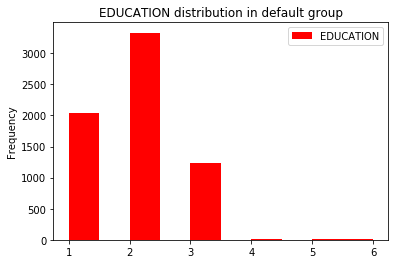

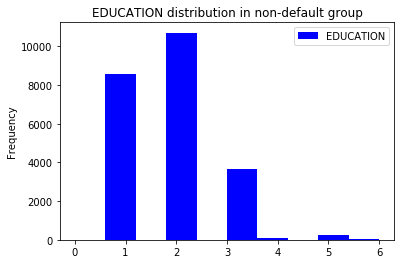

In [122]:
data_def.plot(y='EDUCATION', kind='hist', 
               color='red',  title='EDUCATION distribution in default group')
data_non_def.plot(y='EDUCATION', kind='hist', 
               color='blue',  title='EDUCATION distribution in non-default group')

In [173]:
data_non_def.EDUCATION.value_counts()

2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: EDUCATION, dtype: int64

Во второй группе явно больше доля магистров, а также появляются доктора. При том что распределения в целом похожи, в "синей" группе тяжелее правый хвост.  

#### Сначала проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг
Для этого составим таблицу сопряженности и применим критерий хи-квадрат:

| $Default$ \ $Educ$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 
------------- | -------------| -------------| -------------| -------------| -------------| -------------| -------------| 
1  | 0 | 2036 | 3330 | 1237 | 7 | 18 | 8
0  | 14 | 8549 | 10700 | 3680 | 116 | 262 | 43 

$H_0\colon$ Признаки независимы

$H_1\colon H_0$ неверна

In [206]:
obs = np.array([[0, 2036, 3330, 1237, 7, 18 ,8], [14,  8549, 10700, 3680, 116, 262, 43]])
print("p-value равен", stats.chi2_contingency(obs)[1])

p-value равен 1.2332626245415958e-32


На уровне значимости 0.05 нулевая гипотеза отвергается, т.е. признаки зависимы между собой.

В качестве наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг может использоваться таблица выше, но в ячейках бы стояли разности между ожидаемыми и наблюдаемыми значениями.

Чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости, можно выровнять выборки, повторив некоторые категории образовния несколько раз.

#### Выясним, наличие каких образований является наилучшим и наихудшим индикаторами того, что человек отдаст долг
Для этого рассчитаем доли невозврата кредита для каждого из типов образования и выберем крайние.

In [276]:
data_educ = data[["EDUCATION", "default"]]
props = []
for i in range(7):
    props.append(sum(data_educ[data_educ["EDUCATION"] == i]["default"]) / sum(data_educ["EDUCATION"] == i))
np.argmin(props), np.argmax(props)

(0, 3)

Выходит, что наилучшим того, что человек отдаст долг, является докторская степень, а худшим - среднее образование.

### Задание 4. Семейное положение (MARRIAGE)

Нарисуем графики, иллюстрирующие распределения семейного положения в изучаемых группах:

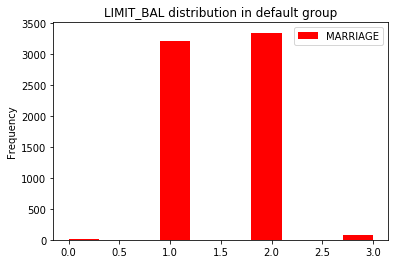

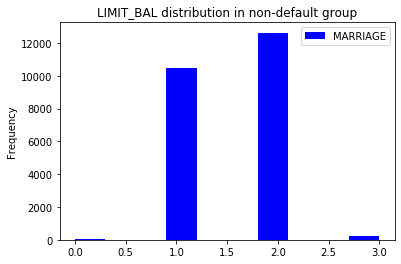

In [146]:
data_def.plot(y='MARRIAGE', kind='hist', 
               color='red',  title='LIMIT_BAL distribution in default group')
data_non_def.plot(y='MARRIAGE', kind='hist', 
               color='blue',  title='LIMIT_BAL distribution in non-default group')

Можно использовать корреляцию Мэтьюса, но для этого придётся избавляться от крайних значений. Чтобы этого не делать, используем коэффициент V Крамера. Ниже матрица сопряженности:

| $Default$ \ $Mar$ | 0 | 1 | 2 | 3 | $\sum$
------------- | -------------| -------------| -------------| -------------|-------------| 
1  | 5 | 3206 | 3341 | 84 | 6636
0  | 49 | 10453 | 12623 | 239 | 23364 
$\sum$ | 54 | 13659 | 15964 | 323  | 30000

In [204]:
obs = np.array([[5, 3206, 3341,84], [49, 10453, 12623, 239]])
print("коэффициент V Крамера равен", (stats.chi2_contingency(obs)[0] / (sum(obs)))**0.5)

коэффициент V Крамера равен 0.034478203662766466


Проверим полученное значение с помощью критерия хи-квадрат:

$H_0\colon$ Признаки независимы

$H_1\colon H_0$ неверна

In [205]:
print("p-value равен", stats.chi2_contingency(obs)[1])

p-value равен 8.825862457577375e-08


На уровне значимости 0.05 нулевая гипотеза отвергается, т.е. признаки зависимы между собой.

Значит, риск невозврата слабо положительно связан с семейным положением.

### Задание 5. Возраст (AGE)

Нарисуем графики, иллюстрирующие распределения возраста в изучаемых группах:

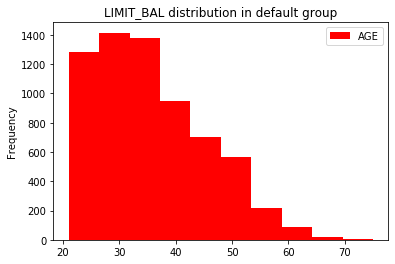

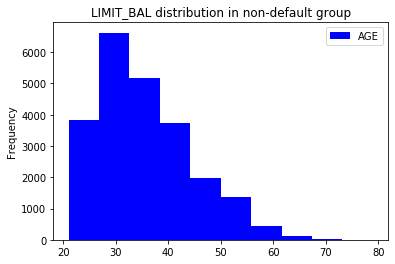

In [145]:
data_def.plot(y='AGE', kind='hist', 
               color='red',  title='LIMIT_BAL distribution in default group')
data_non_def.plot(y='AGE', kind='hist', 
               color='blue',  title='LIMIT_BAL distribution in non-default group')

Из графиков видно, что медиана кредитного лимита тех, кто не вернул долг (красный график), лежит правее.

Также можно предположить, что распределение non-default group более центрированно относительно 30 лет.

#### Проверим гипотезу А 
Требуется проверить гипотезу о равенстве медианных значений возраста с помощью интервальной оценки. Из графиков видно, что возраст распределен не нормально, поэтому воспользуемся bootstrap-ом аналогично тому, как мы действовали в лекциях.

In [142]:
#Здесь мы строим по 1000 псевдоподвыборок из двух данных и находим медианные значения для них.
default_ages = data_def.AGE.values
non_default_ages = data_non_def.AGE.values

default_median_scores = list(map(np.median, get_bootstrap_samples(default_ages, 1000)))
non_default_median_scores = list(map(np.median, get_bootstrap_samples(non_default_ages, 1000)))

In [143]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(default_median_scores, non_default_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1.  0.]


Полученная интервальная оценка разности медиан включает 0, значит, мы не можем отвергнуть гипотезу о равенстве медианных значений возраста.

#### Проверим гипотезу B
Требуется проверить гипотезу о равенстве распределений с помощью одного из непараметрических критериев проверки равенства средних. Используем ранговый критерий Манна-Уитни, потому что он является двухвыборочным критерием для независимых выборок (очевидно, выборки default и non-default независимы). Проверяется следующая гипотеза:

$H_0\colon F_{X_{def}}(x) = F_{X_{non}}(x)$

$H_1\colon F_{X_{def}}(x) = F_{X_{non}}(x + \Delta), \Delta\neq 0$

In [144]:
print("p-value is", stats.mannwhitneyu(default_ages, non_default_ages)[1])

p-value is 0.1862517717449308


Нулевая гипотеза не отвергается на уровне значимости 0.05 в пользу альтернативы.

Полученные результаты, скорее, значимы с практической точки зрения.

## Спасибо за проверку :)